<center> <h1>PREDICCIÓN DEL SUEÑO</h1> </center>
<center> <h3>CREACIÓN SUBCONJUNTOS DE TRAIN Y TEST</h3> </center>
<center> <h4>Noemi González, Roberto Holgado y Carmen Plaza</h4> </center>

### Índice de contenidos de este Notebook

En este Notebook se realiza la separación del dataframe en los subgrupos de Train y Test. Como primera aproximación se ha decidido trabajar con un total de 50 ventanas por sujeto y no con todas, por cuestiones de tiempo de ejecución.

    1. Creación de los conjuntos Train y Test
    2. Preparación datos de entrada y salida

In [20]:
import os
import numpy as np
import pandas as pd
from random import sample
import statistics as stats
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn import preprocessing

Se carga el dataframe creado con las características extraídas de todos los sujetos:

In [21]:
df= pd.read_csv('features.csv')

In [22]:
df.sample(10)

,Min_hr,Max_hr,Mean_hr,Men_acc_sqrt,Min_acc_x,Max_acc_x,Mean_acc_x,Min_acc_y,Max_acc_y,Mean_acc_y,Min_acc_z,Max_acc_z,Mean_acc_z,Etiquetas binarias,Etiquetas multiclase,ID
21173,56.0,58.0,56.80,1.01,-0.01,0.00,-0.00,0.06,0.06,0.06,1.00,1.01,1.00,1.0,2.0,25.0
2833,57.0,59.0,58.00,1.00,0.68,0.69,0.69,-0.50,-0.49,-0.50,-0.54,-0.53,-0.54,1.0,2.0,3.0
3748,77.0,80.0,78.67,1.00,-0.29,-0.28,-0.28,0.90,0.91,0.91,-0.31,-0.30,-0.30,1.0,3.0,4.0
4543,68.0,70.0,69.17,1.00,-0.45,-0.43,-0.44,-0.02,0.00,-0.01,-0.91,-0.89,-0.90,1.0,1.0,4.0
943,58.0,63.0,61.33,1.00,0.75,0.76,0.75,-0.03,-0.03,-0.03,-0.66,-0.65,-0.66,1.0,2.0,1.0
454,58.0,59.0,58.67,1.00,-0.29,-0.28,-0.28,-0.70,-0.69,-0.70,0.65,0.66,0.66,1.0,2.0,0.0
20508,59.0,59.0,59.00,1.00,0.28,0.29,0.28,-0.20,-0.19,-0.20,-0.94,-0.92,-0.93,1.0,3.0,25.0
8443,66.0,68.0,66.67,1.00,0.53,0.55,0.54,0.10,0.11,0.10,-0.84,-0.82,-0.83,1.0,2.0,10.0
691,55.0,57.0,56.17,1.01,0.27,0.29,0.28,0.95,0.99,0.96,0.06,0.09,0.07,0.0,5.0,0.0
17493,68.0,71.0,69.50,1.00,0.64,0.66,0.65,0.17,0.19,0.18,-0.74,-0.73,-0.74,0.0,5.0,21.0


## 1. Creación de los conjuntos Train y Test

Se crean 2 listas aleatorias con una **proporción de 3:1** para Train y Test.

In [23]:
lista = list(range(31)) # Lista de 31 números
suj_train = sample(lista,k=24) # 21 sujetos de train
suj_test = [el for el in lista if el not in suj_train] #Los que no están en train van a test (7)

print(len(suj_train),'sujetos de train:',suj_train)
print(len(suj_test),'sujetos de test:',suj_test)

24 sujetos de train: [12, 19, 27, 28, 11, 10, 7, 17, 15, 9, 16, 14, 4, 23, 2, 25, 21, 24, 20, 22, 18, 30, 8, 26]
7 sujetos de test: [0, 1, 3, 5, 6, 13, 29]


Con cada una de las listas de sujetos anteriores, se crean los conjuntos de Train y Test de manera que no se mezclen los sujetos entre cada uno de los dos subconjuntos:

In [24]:
train_matr = []
test_matr = []
id = df['ID']

for i in suj_train:    
    idx = []
    for s in id:
        if s==i:
            idx.append(True)
        else:
            idx.append(False)
    m = df[idx]
    train_matr.append(m)

for i in suj_test:    
    idx = []
    for s in id:
        if s==i:
            idx.append(True)
        else:
            idx.append(False)
    m = df[idx]
    test_matr.append(m)

En este caso, los conjuntos de Train y Test se han creado con **50 ventanas** deslizantes y no con todas.

In [25]:
lista_ventanas=list(np.linspace(0,0.99,100)) #[0,1/10,1/5,3/10,4/10,5/10,6/10,7/10,8/10,9/10]

Train = pd.DataFrame()  
for i in range(len(train_matr)):
    lista_multi=[int(element * len(train_matr[i])) for element in lista_ventanas]
    ven1=train_matr[i].iloc[lista_multi]
    Train=Train.append(ven1)

Test = pd.DataFrame()  
for i in range(len(test_matr)):
    lista_multi=[int(element * len(test_matr[i])) for element in lista_ventanas]
    ven2=test_matr[i].iloc[lista_multi]
    Test=Test.append(ven2)

### 2.Normalización de los datos

In [26]:
Train_tt=Train.copy()
Test_tt=Test.copy()

In [27]:
Etiquetas = Train[['Etiquetas binarias','Etiquetas multiclase','ID']]

In [28]:
X_train=Train_tt.drop(['Etiquetas binarias','Etiquetas multiclase','ID'], axis = 1) 
columns_name=list(X_train.columns)
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_transformed = scaler.transform(X_train)
Train_transformed=pd.DataFrame(X_train_transformed, columns=columns_name)
Train_transformed['Etiquetas multiclase'], Train_transformed['Etiquetas binarias'], Train_transformed['ID'] = [Train['Etiquetas multiclase'].values, Train['Etiquetas binarias'].values, Train['ID'].values]

X_test=Test_tt.drop(['Etiquetas binarias','Etiquetas multiclase','ID'], axis = 1) 
scaler = preprocessing.StandardScaler().fit(X_train)
X_test_transformed = scaler.transform(X_test)
Test_transformed=pd.DataFrame(X_test_transformed, columns=columns_name)
Test_transformed['Etiquetas multiclase'], Test_transformed['Etiquetas binarias'], Test_transformed['ID'] = [Test['Etiquetas multiclase'].values, Test['Etiquetas binarias'].values, Test['ID'].values]

In [29]:
#Train_transformed

In [30]:
#Train

In [31]:
#Test.sample(10)

In [32]:
Train.to_csv('Train.csv', header=True, index=False)
Test.to_csv('Test.csv', header=True, index=False)
Train_transformed.to_csv('Train_transformed.csv', header=True, index=False)
Test_transformed.to_csv('Test_transformed.csv', header=True, index=False)

COMPARAR LOS DOS SUBCONJUNTOS

HISTOGRAMA DATOS TRAIN


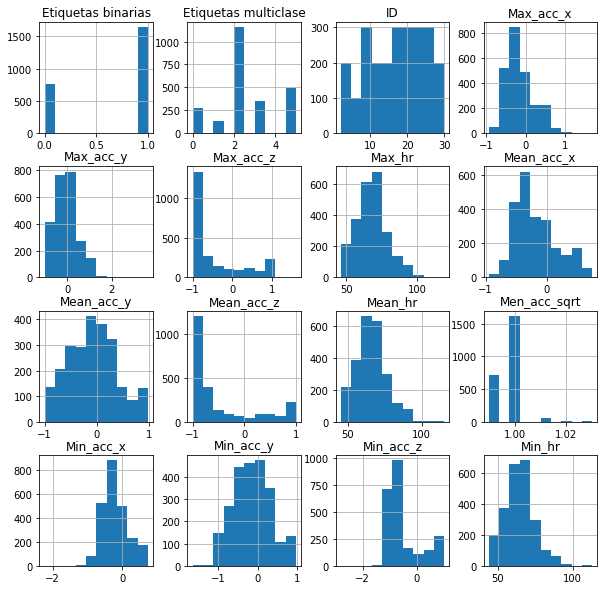

In [33]:
print(chr(27)+"[1;34m"+'HISTOGRAMA DATOS TRAIN')
Train.hist(figsize=(10, 10))
plt.show()

In [34]:
Train.describe()

,Min_hr,Max_hr,Mean_hr,Men_acc_sqrt,Min_acc_x,Max_acc_x,Mean_acc_x,Min_acc_y,Max_acc_y,Mean_acc_y,Min_acc_z,Max_acc_z,Mean_acc_z,Etiquetas binarias,Etiquetas multiclase,ID
count,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000
mean,64.423333,68.028750,66.148629,0.997312,-0.207367,-0.145054,-0.175538,-0.132188,-0.036442,-0.083042,-0.508175,-0.428650,-0.474133,0.682500,2.483333,17.000000
std,9.816233,10.844596,10.125114,0.005115,0.356605,0.362438,0.340616,0.478214,0.505498,0.465524,0.632130,0.643785,0.625606,0.465601,1.504659,7.742199
min,44.000000,46.000000,45.330000,0.990000,-2.230000,-0.940000,-0.950000,-1.660000,-1.000000,-1.000000,-2.800000,-1.000000,-1.000000,0.000000,0.000000,2.000000
25%,58.000000,61.000000,59.200000,0.990000,-0.450000,-0.410000,-0.420000,-0.470000,-0.410000,-0.432500,-0.910000,-0.880000,-0.890000,0.000000,2.000000,10.750000
50%,64.000000,68.000000,65.670000,1.000000,-0.290000,-0.250000,-0.270000,-0.140000,-0.050000,-0.100000,-0.820000,-0.770000,-0.800000,1.000000,2.000000,17.500000
75%,70.000000,74.000000,72.000000,1.000000,-0.010000,0.070000,0.030000,0.190000,0.260000,0.220000,-0.330000,-0.090000,-0.250000,1.000000,3.000000,23.250000
max,113.000000,119.000000,115.170000,1.030000,0.740000,1.700000,0.750000,0.990000,3.620000,0.990000,1.000000,1.610000,1.010000,1.000000,5.000000,30.000000


HISTOGRAMA DATOS TEST


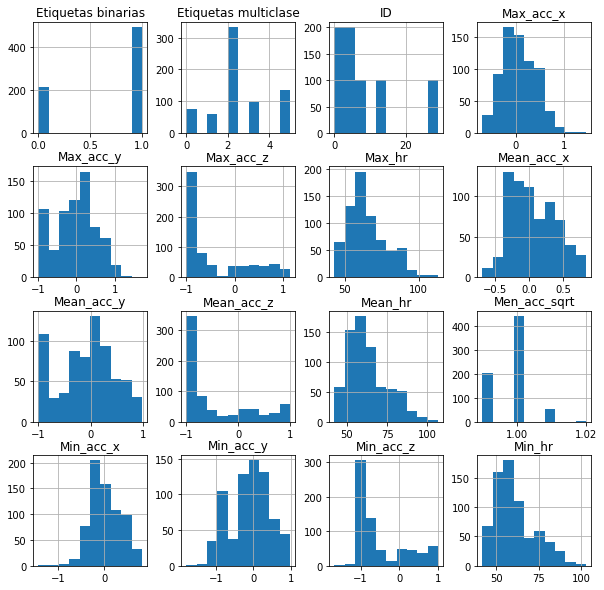

In [35]:
print(chr(27)+"[1;34m"+'HISTOGRAMA DATOS TEST')
Test.hist(figsize=(10, 10))
plt.show()

In [36]:
Test.describe()

,Min_hr,Max_hr,Mean_hr,Men_acc_sqrt,Min_acc_x,Max_acc_x,Mean_acc_x,Min_acc_y,Max_acc_y,Mean_acc_y,Min_acc_z,Max_acc_z,Mean_acc_z,Etiquetas binarias,Etiquetas multiclase,ID
count,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000
mean,61.228571,64.798571,62.878843,0.997886,0.023529,0.077214,0.051314,-0.094729,-0.017643,-0.060814,-0.486314,-0.406414,-0.443000,0.697143,2.427143,8.142857
std,11.549324,12.976737,11.985697,0.005770,0.344937,0.344315,0.326064,0.532765,0.522719,0.511214,0.645565,0.668658,0.644254,0.459823,1.494522,9.394068
min,42.000000,43.000000,42.330000,0.990000,-1.440000,-0.680000,-0.680000,-1.780000,-0.990000,-0.990000,-1.670000,-1.000000,-1.000000,0.000000,0.000000,0.000000
25%,53.000000,55.000000,54.170000,0.990000,-0.240000,-0.210000,-0.212500,-0.440000,-0.322500,-0.380000,-0.950000,-0.930000,-0.940000,0.000000,2.000000,1.000000
50%,59.000000,62.000000,60.365000,1.000000,-0.010000,0.040000,0.025000,-0.020000,0.020000,0.000000,-0.840000,-0.780000,-0.800000,1.000000,2.000000,5.000000
75%,68.000000,73.000000,70.177500,1.000000,0.300000,0.330000,0.320000,0.300000,0.350000,0.310000,0.002500,0.142500,0.072500,1.000000,3.000000,13.000000
max,103.000000,113.000000,106.570000,1.020000,0.830000,1.450000,0.830000,0.970000,1.700000,0.970000,0.990000,1.150000,1.000000,1.000000,5.000000,29.000000


1.0    1638
0.0     762
Name: Etiquetas binarias, dtype: int64
1.0    488
0.0    212
Name: Etiquetas binarias, dtype: int64


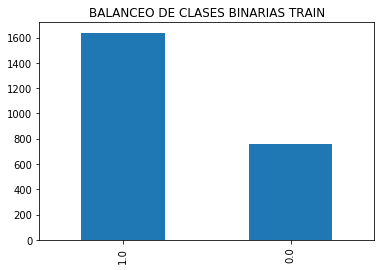

<Figure size 432x288 with 0 Axes>

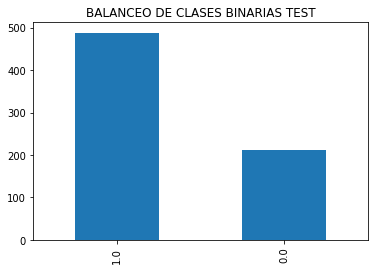

In [37]:
Train['Etiquetas binarias'].value_counts().plot.bar(title="BALANCEO DE CLASES BINARIAS TRAIN")
plt.figure()
print(Train["Etiquetas binarias"].value_counts() )

#Test['Etiquetas binarias'].value_counts().plot.bar(title="BALANCEO DE CLASES BINARIAS TEST")
plt.figure()
Test['Etiquetas binarias'].value_counts().plot.bar(title="BALANCEO DE CLASES BINARIAS TEST")
print(Test["Etiquetas binarias"].value_counts() )

2.0    1154
5.0     492
3.0     354
0.0     270
1.0     130
Name: Etiquetas multiclase, dtype: int64
2.0    332
5.0    137
3.0     97
0.0     75
1.0     59
Name: Etiquetas multiclase, dtype: int64


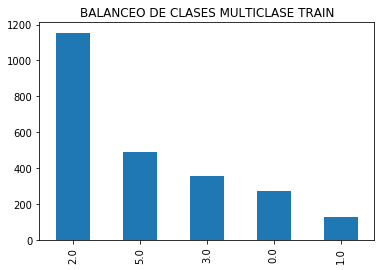

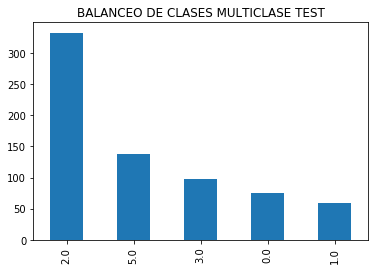

<Figure size 432x288 with 0 Axes>

In [38]:
Train['Etiquetas multiclase'].value_counts().plot.bar(title="BALANCEO DE CLASES MULTICLASE TRAIN")
plt.figure()
print(Train["Etiquetas multiclase"].value_counts() )

Test['Etiquetas multiclase'].value_counts().plot.bar(title="BALANCEO DE CLASES MULTICLASE TEST")
plt.figure()
print(Test["Etiquetas multiclase"].value_counts() )